# 1.0 Imports

###### 1.1 Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor

import pickle

import time

tempo_agora = time.time() # Tempo inicial

###### 1.2 Loading series

In [2]:
df = pickle.load(open('D:\\my drive\\pessoal\\projetos\\bar_sales_forecast\\bar_sales_forecast\\exportings\\df_to_modeling.pkl', 'rb'))
prepared_data = pickle.load(open('D:\\my drive\\pessoal\\projetos\\bar_sales_forecast\\bar_sales_forecast\\exportings\\prepared_data.pkl', 'rb'))
X_train = prepared_data[0]
y_train = prepared_data[1]
X_test = prepared_data[2]
y_test = prepared_data[3]

# 2.0 ML Modeling

## 2.1 Baseline

In [3]:
backup = df.copy()

<AxesSubplot:xlabel='date'>

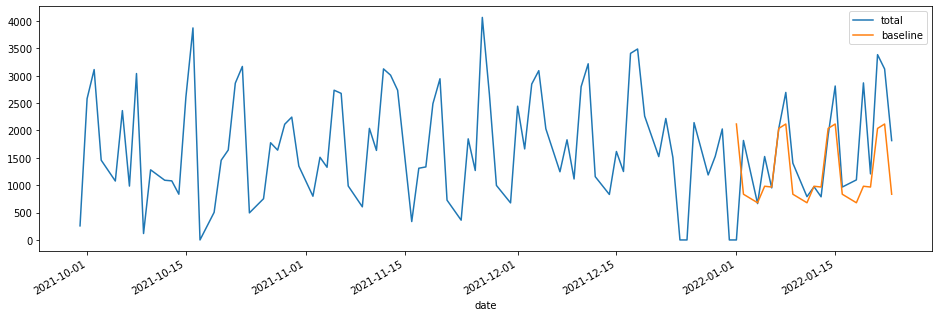

In [4]:
df1 = backup.copy()

day_week_mean = df1.groupby('day_of_week').agg({'total':'mean'}).to_dict()['total']

predict_indexes = df1['2022-01-01':'2022-01-23'].index

df1.loc[predict_indexes, 'baseline'] = df1['day_of_week'].map(day_week_mean)

df1[['total', 'baseline']][-100:].plot(figsize=(16, 5))

<AxesSubplot:xlabel='total', ylabel='baseline'>

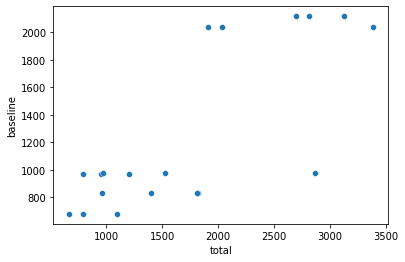

In [5]:
sns.scatterplot(data=df1.loc[df1['total']!=0], x='total', y='baseline')

**MAE**

In [6]:
df1['square_error'] = (df1['total'] - df1['baseline']) ** 2

df1['absolut_error'] = np.sqrt(df1['square_error'])

print(f"MAE = R$ {round(df1['absolut_error'].mean(),2)}")

MAE = R$ 597.08


**MAPE**

In [7]:
print(f"MAPE = {round(np.mean(df1.loc[df1['total']!=0, 'absolut_error'] / df1.loc[df1['total']!=0, 'total'])*100, 2)}%")

MAPE = 25.68%


## 2.2 ARIMA

In [8]:
backup = df.copy()

D:\My Drive\Pessoal\Projetos\environments\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\My Drive\Pessoal\Projetos\environments\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\My Drive\Pessoal\Projetos\environments\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\My Drive\Pessoal\Projetos\environments\data_science\

<AxesSubplot:xlabel='date'>

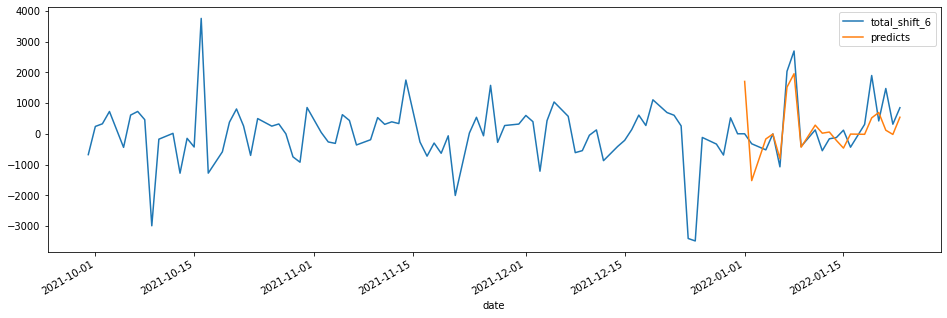

In [9]:
df = backup.copy()

df['shift_6'] = df['total'].shift(6)

df['total_shift_6'] = df['total'] - df['shift_6']

cols = ['Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

df.dropna(inplace=True)

arima_model = ARIMA(endog=df['total_shift_6'],
                    exog = df[cols],
                    order=(6, 0, 6), enforce_stationarity=False,  enforce_invertibility=False)

arima_fit = arima_model.fit()

arima_pred = arima_fit.predict(start='2022-01-01', end='2022-01-23')

df['predicts'] = arima_pred

df[['total_shift_6', 'predicts']][-100:].plot(figsize=(16, 5))

<AxesSubplot:xlabel='total_shift_6', ylabel='predicts'>

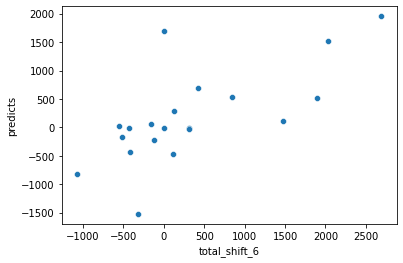

In [10]:
sns.scatterplot(data=df, x='total_shift_6', y='predicts')

**MAE**

In [11]:
df['square_error'] = (df['total_shift_6'] - df['predicts']) ** 2

df['absolut_error'] = np.sqrt(df['square_error'])

print(f"MAE = R$ {round(df['absolut_error'].mean(),2)}")

MAE = R$ 541.1


**MAPE**

In [12]:
df.tail(20)

,Bar,Bilhar,Bomboniere,Cozinha,Gorjeta,Tabacaria,total,day_of_week,shifted_6,total_proc,...,shift_12,Saturday,Sunday,Thursday,Tuesday,Wednesday,total_shift_6,predicts,square_error,absolut_error
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,0.00,0.0,0.0,0.0,0.0,0.00,0.00,Saturday,0.00,0.00,...,-269.79,1,0,0,0,0,0.00,1702.829653,2.899629e+06,1702.829653
2022-01-02,861.01,415.4,15.4,412.1,109.0,3.01,1815.92,Sunday,2141.30,325.38,...,-1105.44,0,1,0,0,0,-325.38,-1523.245250,1.434881e+06,1197.865250
2022-01-04,205.20,293.6,3.3,129.4,29.2,3.00,663.70,Tuesday,1186.60,522.90,...,-690.80,0,0,0,1,0,-522.90,-168.892630,1.253212e+05,354.007370
2022-01-05,624.50,460.7,2.2,334.9,73.4,27.01,1522.71,Wednesday,1525.71,3.00,...,-602.62,0,0,0,0,1,-3.00,-8.744506,3.299935e+01,5.744506
2022-01-06,337.80,421.7,3.3,129.5,34.3,24.00,950.60,Thursday,2025.61,1075.01,...,-256.79,0,0,1,0,0,-1075.01,-810.623673,6.990013e+04,264.386327
2022-01-07,1024.30,652.0,4.4,236.3,78.1,36.00,2031.10,Friday,0.00,-2031.10,...,3405.55,0,0,0,0,0,2031.10,1516.253683,2.650667e+05,514.846317
2022-01-08,1347.75,720.6,2.2,428.8,174.6,18.50,2692.45,Saturday,0.00,-2692.45,...,3485.60,1,0,0,0,0,2692.45,1954.142937,5.450973e+05,738.307063
2022-01-09,792.90,173.3,0.0,341.9,93.7,0.00,1401.80,Sunday,1815.92,414.12,...,119.44,0,1,0,0,0,-414.12,-435.942798,4.762345e+02,21.822798
2022-01-11,401.20,240.5,3.3,117.7,27.0,0.00,789.70,Tuesday,663.70,-126.00,...,334.80,0,0,0,1,0,126.00,280.886849,2.398994e+04,154.886849


In [13]:
print(f"MAPE = {round(np.mean(df.loc[(df['absolut_error'].notnull())&(df['total_shift_6']!=0), 'absolut_error'] / df.loc[(df['absolut_error'].notnull())&(df['total_shift_6']!=0), 'total_shift_6'])*100, 2)}%")

MAPE = 4.23%


## 2.3 XGboost

<AxesSubplot:>

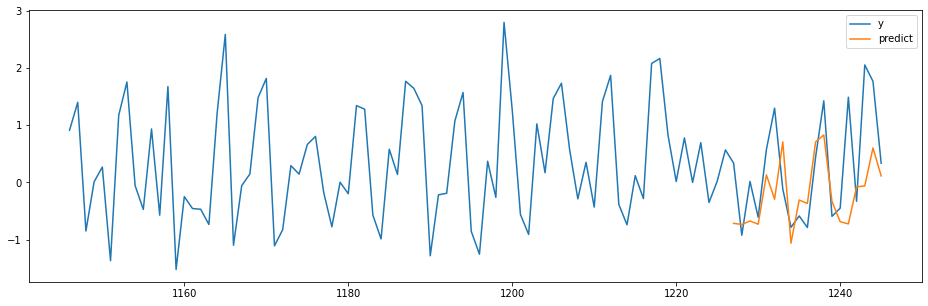

In [14]:
model = XGBRegressor()

model_fit = model.fit(X_train, y_train)

predicts = model_fit.predict(X_test)

df = pd.DataFrame()
temp = pd.DataFrame()

df['y'] = y_train
temp['y'] = y_test
df = pd.concat([df, temp], axis=0).reset_index(drop=True)
df.loc[:1226, 'predict'] = np.nan
df.loc[1227:, 'predict'] = predicts
df[['y', 'predict']][-100:].plot(figsize=(16, 5))

<AxesSubplot:>

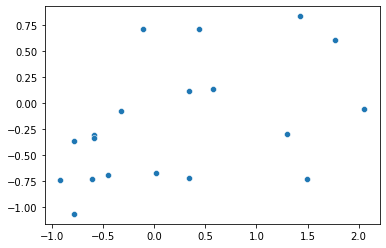

In [15]:
sns.scatterplot(x=y_test, y=predicts)

**MAE**

In [16]:
square_error = (y_test - predicts) ** 2

absolute_error = np.sqrt(square_error)

print(f"MAE = {round(np.mean(absolute_error), 2)}")

MAE = 0.7


**MAPE**

In [17]:
print(f"MAPE = {np.round(np.mean(absolute_error/y_test)*100, 2)}%")

MAPE = 188.88%


# Time

In [18]:
print(f'O projeto está processando em {round((time.time() - tempo_agora) / 60, 2)} minutos')

O projeto está processando em 0.08 minutos
